# Bike data ETL pipeline and visualization

In [1]:
import pyodbc
import pandas as pd

server = 'database-2.crzjs7ppdt48.us-west-1.rds.amazonaws.com' 
database = 'bikes'
username = 'admin'
password = 'HbO7Sc68jRylFAFCvACE'
driver ='{MySQL ODBC 8.1 Unicode Driver}'

## Make a Connection
We first want to import pyodbc and pandas but why? Pyodbc is the way we access our aws database so we have set our server. In order to access our database we need to use pyodbc connect and assign all of our set variables to and import pyodbc and pandas. We use pandas to store our data in a dataframe.

In [2]:
#extract data from MySQL Server
def extract():
    try:
        #connecting to our database
        cnxn = pyodbc.connect(driver=driver, host=server, database=database, user=username, password=password)
        cursor = cnxn.cursor()
        #SQL query string 
        query = (
                "SELECT * FROM bikes.bike_data "
                "WHERE (WheelSize = '27.5\"' OR WheelSize = '29\"') "
                "AND (Type = 'Hardtail Mountain Bikes' OR Type = 'Full Suspension Mountain Bikes')"
                )
        #This use a cursor to execute the select
        results = cursor.execute(query)
        columns = [column[0] for column in cursor.description]

        #please investigate this line of code
        results = [dict(zip(columns, row)) for row in cursor.fetchall()]

        return(pd.DataFrame(results))
    except pyodbc.Error as e:
        print("An error occurred:", e)
    finally:
        cursor.close()
        cnxn.close()

result = extract()

## E stands for Extract
In this case we need to create a try catch block within a method to connect to our database. Then we need to use a cursor and set our query variable which holds our SQL query string. Then we have to use the execute method from our cursor to execute our query. Then we must unpack and get the columns and store them in a variable called columns. Then we need to unpack the rest of our results by using zip to combine two or more lists (or any other iterables) into a single iterable, where elements from corresponding positions are paired together. Then we use dict to create a dictionary. Then return our answer in a dataframe. This dataframe holds the result of our SQL query.

In [3]:
from urllib.parse import urlparse
import re

def transform(result):
    
    states1 = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    result.rename(columns={'SizeCM':'State', 'Groupset':'City'}, inplace=True)

    data = []

    for url in result.Product_URL:
        parsed_url = urlparse(url)
        path_segments = parsed_url.path.strip('/').split('/')

        state = path_segments[3].upper()
        city = path_segments[4].replace('-', ' ').title()

        data.append({'State':state, 'City':city})

    df = pd.DataFrame(data)

    result['State'] = df['State']
    result['City'] = df['City']

    result = result.drop(columns='Price_was', axis=0)

    result = result[result['State'].isin(states1)]

    for index, row in result.iterrows():
        # Remove non-numeric characters and convert to float
        numeric_price_str = re.sub(r'[^0-9.]', '', row['Price_now'])
        
        if numeric_price_str:
            result.at[index, 'Price_now'] = float(numeric_price_str)
        else:
            result.at[index, 'Price_now'] = None

    result=result.dropna()

    return(result)


## T stands for Transform
We are going to import urlparse,parse_qs and re. The method starts out by taking one parameter. So we have a few things to do. We can use a variable to store our the states because the location is in the data. Then we rename two of the columns because we going to extract our state and subsequitly the city. We use url parse in a loop to strip our url of all other things and append that data into a variable called data which holds City and State. We then drop the price_was because its not needed and check to see if the state is valid using our states1 variable. We then create a loop to transform our strings in price_now to a float. We then drop all nulls.

In [4]:
trnsfrmdrslt = transform(result)

def load(trnsfrmdresult):
    trnsfrmdresult.to_csv("bkeanlytcs.csv")
    
load(trnsfrmdrslt)

## The Data visualized

<AxesSubplot: >

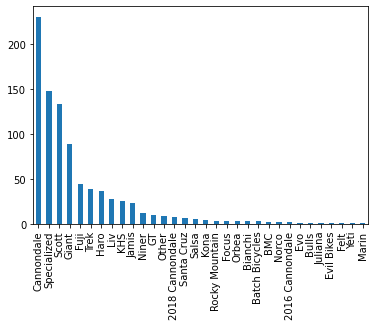

In [5]:
trnsfrmdrslt['Brand'].value_counts().plot(kind='bar')

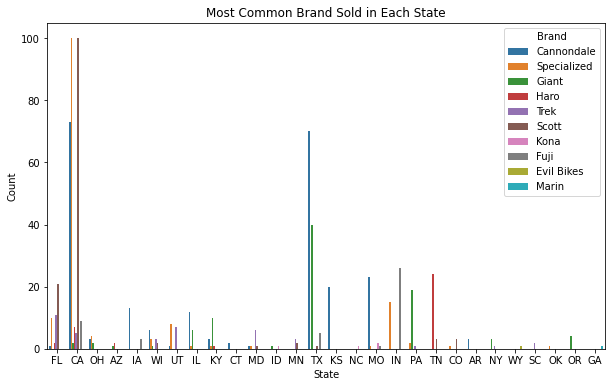

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

most_common_brands = trnsfrmdrslt.groupby('State')['Brand'].apply(lambda x: x.value_counts().index[0])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='State', hue='Brand', data=trnsfrmdrslt[trnsfrmdrslt['Brand'].isin(most_common_brands)])
plt.title('Most Common Brand Sold in Each State')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Brand')
plt.show()

<AxesSubplot: ylabel='Brand'>

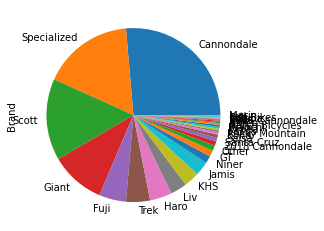

In [7]:
trnsfrmdrslt['Brand'].value_counts().plot(kind="pie")

### Interpretting visualization
The most common brands by a state like tx wound be cannondale. We also see that california is apparently just loves mountain biking. We also see that Cannondale is the most ridden brand.